# Transfer learning with Keras and TensorFlow

The trogons and quetzals are birds in the order Trogoniformes which contains only one family, the Trogonidae. The family contains 39 species in seven genera. The fossil record of the trogons dates back 49 million years to the Early Eocene. They might constitute a member of the basal radiation of the order Coraciiformes or be closely related to mousebirds and owls. The word trogon is Greek for "nibbling" and refers to the fact that these birds gnaw holes in trees to make their nests.

https://en.wikipedia.org/wiki/Quetzal

https://en.wikipedia.org/wiki/Trogon

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Importing and pre-processing images

If you have trouble with these cells you may need to install [Pillow](https://pillow.readthedocs.io/en/5.1.x/) version 4.0.0 in Windowns 10 :

`conda install pillow==4.0.0`

In [2]:
from keras.preprocessing.image import ImageDataGenerator
# directories
images_dir = os.path.join(os.getcwd(),'data','quetzales-trogons')
train_dir = os.path.join(images_dir, 'train')
test_dir = os.path.join(images_dir, 'test')

# image dimensions
n_train = 700
n_test = 160
input_size = (224, 224)

Using TensorFlow backend.


In [3]:
## Converting images to Numpy-arrays
image_data_generator = ImageDataGenerator(rescale=1./255)

## Train images
train_image_gen = image_data_generator.flow_from_directory(train_dir, target_size=input_size, 
                                                          batch_size=n_train, class_mode='binary')
X_train, y_train = next(train_image_gen)

Found 700 images belonging to 2 classes.


In [4]:
## Test images
test_image_gen = image_data_generator.flow_from_directory(test_dir, target_size=input_size, 
                                                          batch_size=n_test, class_mode='binary')
X_test, y_test = next(test_image_gen)

Found 160 images belonging to 2 classes.


### Taking a look at some of the pictures

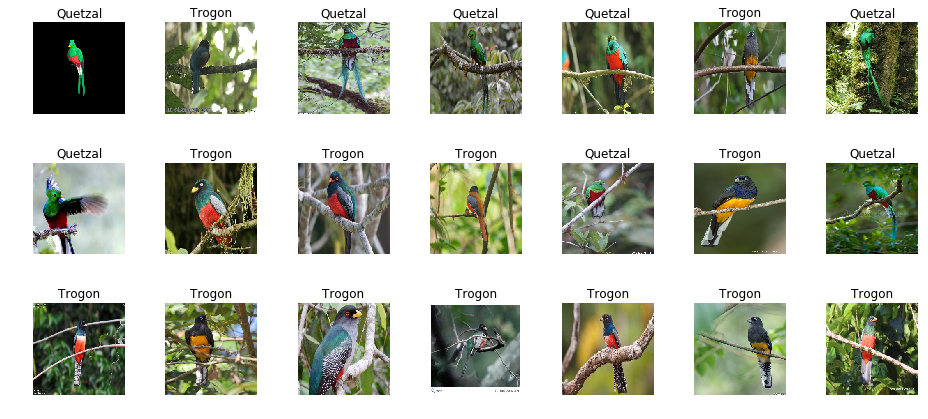

In [5]:
categories = {0:'Quetzal', 1:'Trogon'}

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(13,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(categories[y_train[i]])
    ax.axis('off')

fig.tight_layout()

## Getting the convolutional base from Keras: VGG16

**Very Deep Convolutional Networks for Large-Scale Image Recognition**

Karen Simonyan, Andrew Zisserman
[paper here](https://arxiv.org/pdf/1409.1556.pdf)

In [6]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape= input_size + (3,))

In [7]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Getting features from the Convolutional Base

In [8]:
batch_size = 10

## Training features
X_train_features = np.zeros(shape=(n_train, 7, 7, 512))
for i in range(n_train//batch_size):
    index_start = i*batch_size
    index_end = index_start + batch_size
    X_train_features[index_start:index_end] = conv_base.predict(X_train[index_start:index_end])
    
X_train_features = X_train_features.reshape(n_train, 7 * 7 * 512)

## Testing features
X_test_features = np.zeros(shape=(n_test, 7, 7, 512))
for i in range(n_test//batch_size):
    index_start = i*batch_size
    index_end = index_start + batch_size
    X_test_features[index_start:index_end] = conv_base.predict(X_test[index_start:index_end])

X_test_features = X_test_features.reshape(n_test, 7 * 7 * 512)

## Trainning the (top) DNN

In [13]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim= 7 * 7 * 512))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train_features, y_train, epochs=25, batch_size=16)

Epoch 1/25
700/700 [==============================] - 1s 1ms/step - loss: 0.8683 - acc: 0.6000
Epoch 2/25
700/700 [==============================] - 0s 690us/step - loss: 0.5506 - acc: 0.7171
Epoch 3/25
700/700 [==============================] - 0s 678us/step - loss: 0.4035 - acc: 0.8057
Epoch 4/25
700/700 [==============================] - 1s 720us/step - loss: 0.3470 - acc: 0.8329
Epoch 5/25
700/700 [==============================] - 0s 677us/step - loss: 0.2831 - acc: 0.8700
Epoch 6/25
700/700 [==============================] - 0s 688us/step - loss: 0.2613 - acc: 0.9000
Epoch 7/25
700/700 [==============================] - 0s 678us/step - loss: 0.2075 - acc: 0.9014
Epoch 8/25
700/700 [==============================] - 0s 695us/step - loss: 0.1638 - acc: 0.9314
Epoch 9/25
700/700 [==============================] - 0s 699us/step - loss: 0.1583 - acc: 0.9443
Epoch 10/25
700/700 [==============================] - 0s 682us/step - loss: 0.1218 - acc: 0.9600
Epoch 11/25
700/700 [==========

## Evaluating the classifier

In [14]:
y_pred = model.predict_classes(X_test_features).reshape(n_test)
test_acc = 100*(y_test == y_pred).mean()
print("Test accuracy {:.1f}%".format(test_acc))

Test accuracy 95.6%


In [15]:
miss_class = X_test[y_test != y_pred]
correct_labels = y_test[y_test != y_pred]
print("Number of missclassified images: ", len(miss_class))

Number of missclassified images:  7


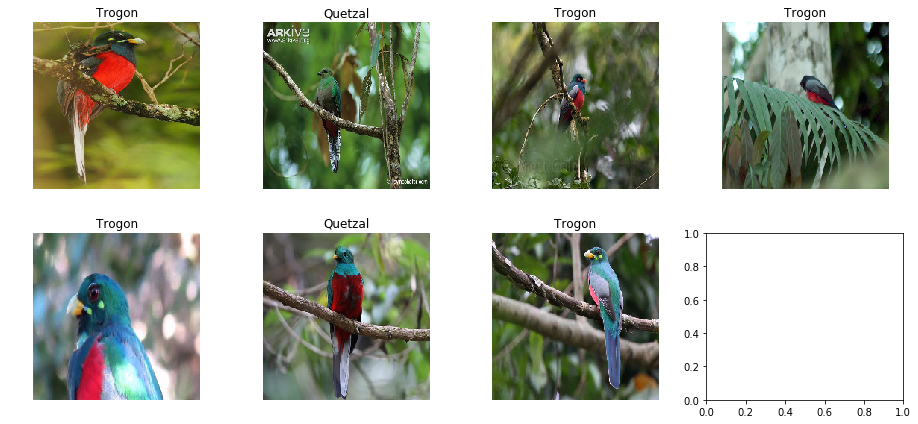

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,6))
axes = axes.flatten()
for i in range(len(correct_labels)):
    axes[i].imshow(miss_class[i])
    axes[i].set_title(categories[correct_labels[i]])
    axes[i].axis('off')

fig.tight_layout()